In [1]:
%load_ext google.cloud.bigquery

In [39]:
%load_ext lab_black

In [44]:
import altair as alt
import pandas as pd

In [84]:
pd.options.display.float_format = "{:.2f}".format

In [25]:
%%bigquery df_article_first_dat --project zenscr-seefood-dev

WITH first_appearance AS (
  SELECT
    article_id,
    MIN(t_dat) first_appearance_t_dat
  FROM `zenscr-seefood-dev.hm_kaggle.transactions` trans
  GROUP BY article_id
)
SELECT
  article_id,
  first_appearance_t_dat
FROM `zenscr-seefood-dev.hm_kaggle.articles`
LEFT JOIN first_appearance
USING (article_id)
ORDER BY first_appearance_t_dat ASC

Downloading: 100%|█████████| 105542/105542 [00:01<00:00, 59929.49rows/s]


In [46]:
df_article_first_dat["first_appearance_t_dat"] = pd.to_datetime(
    df_article_first_dat["first_appearance_t_dat"]
)

In [50]:
alt.Chart(
    df_article_first_dat["first_appearance_t_dat"]
    .value_counts()
    .to_frame()
    .reset_index()
).mark_line().encode(
    x="index", y="first_appearance_t_dat", tooltip=["first_appearance_t_dat"]
).properties(
    width=900
).interactive()

alt.Chart(...)

In [30]:
df_article_first_dat.isna().mean()

article_id                0.000000
first_appearance_t_dat    0.009428
dtype: float64

In [53]:
%%bigquery df_article_base --project zenscr-seefood-dev

SELECT
  dates.obs_dat,
  dates.t_dat,
  trans.article_id,
  EXTRACT(QUARTER FROM dates.t_dat) quarter,
FROM `zenscr-seefood-dev.hm_kaggle_reco.feat_base_dates` dates
LEFT JOIN `zenscr-seefood-dev.hm_kaggle.transactions` AS trans
       ON dates.t_dat = trans.t_dat
WHERE dates.obs_dat = "2020-04-01"

Query complete after 0.00s: 100%|█| 6/6 
Downloading: 100%|█| 23934157/23934157 [


In [54]:
df_article_base

,obs_dat,t_dat,article_id,quarter
0,2020-04-01,2020-03-31,841434001,1
1,2020-04-01,2020-03-31,771970008,1
2,2020-04-01,2020-03-31,841434001,1
3,2020-04-01,2020-03-31,715624008,1
4,2020-04-01,2020-03-31,737040007,1
...,...,...,...,...
23934152,2020-04-01,2019-04-13,697054014,2
23934153,2020-04-01,2019-04-13,747216001,2
23934154,2020-04-01,2019-04-13,475791004,2
23934155,2020-04-01,2019-04-13,689513001,2


In [56]:
df_article_base["t_dat"].agg(["min", "max"])

min    2018-09-20
max    2020-03-31
Name: t_dat, dtype: object

<AxesSubplot:>

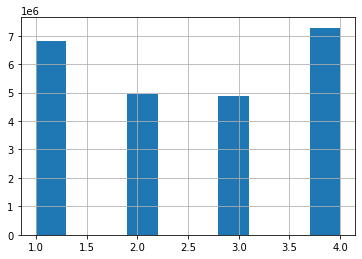

In [55]:
df_article_base["quarter"].hist()

In [67]:
q1_popularity_feat = df_article_base.groupby("article_id").apply(
    lambda g: (g["quarter"] == 1).sum() / g.shape[0]
)

<AxesSubplot:>

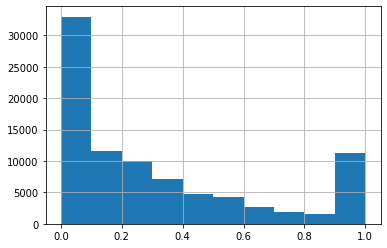

In [69]:
q1_popularity_feat.hist()

In [71]:
%%bigquery df_q1_pop --project zenscr-seefood-dev

SELECT
  dates.obs_dat,
  trans.article_id,
  COUNTIF(EXTRACT(QUARTER FROM dates.t_dat) = 1) / COUNT(*) feat_article_q1_popularity,
FROM `zenscr-seefood-dev.hm_kaggle_reco.feat_base_dates` dates
LEFT JOIN `zenscr-seefood-dev.hm_kaggle.transactions` AS trans
       ON dates.t_dat = trans.t_dat
WHERE dates.obs_dat = "2020-04-01"
GROUP BY obs_dat, article_id


Query is running:
Query executing s
Query complete af

Downloading:   0%
Downloading:   1%
Downloading:   5%
Downloading:  12%
Downloading:  23%
Downloading:  46%
Downloading: 100%


<AxesSubplot:>

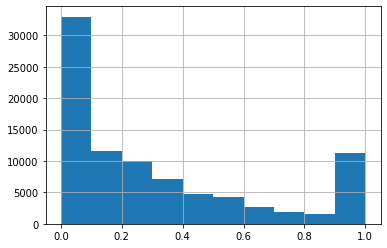

In [73]:
df_q1_pop["feat_article_q1_popularity"].hist()

In [100]:
%%bigquery df_article_feat --project zenscr-seefood-dev

WITH base AS (
  SELECT
    dates.obs_dat,
    dates.t_dat,
    trans.article_id,
    price,
    age
  FROM `zenscr-seefood-dev.hm_kaggle_reco.feat_base_dates` dates
  LEFT JOIN `zenscr-seefood-dev.hm_kaggle.transactions` AS trans
         ON dates.t_dat = trans.t_dat
  LEFT JOIN `zenscr-seefood-dev.hm_kaggle.customers` AS customers
         ON trans.customer_short_id = customers.customer_short_id
),
window_feat_1day AS (
  SELECT
    obs_dat,
    article_id,
    COUNT(*) AS feat_article_num_sales_1day,
    AVG(price) AS feat_article_avg_price_1day
  FROM base
  WHERE t_dat = DATE_SUB(obs_dat, INTERVAL 1 DAY)
  GROUP BY obs_dat, article_id
),
window_feat_3day AS (
  SELECT
    obs_dat,
    article_id,
    COUNT(*) AS feat_article_num_sales_3day,
    AVG(price) AS feat_article_avg_price_3day
  FROM base
  WHERE t_dat >= DATE_SUB(obs_dat, INTERVAL 4 DAY)
  GROUP BY obs_dat, article_id
),
window_feat_7day AS (
  SELECT
    obs_dat,
    article_id,
     COUNT(*) AS feat_article_num_sales_7day,
    AVG(price) AS feat_article_avg_price_7day
  FROM base
  WHERE t_dat >= DATE_SUB(obs_dat, INTERVAL 8 DAY)
  GROUP BY obs_dat, article_id
),
features AS (
  SELECT
    base.obs_dat,
    base.article_id,
    AVG(age) AS feat_article_avg_customer_age,
    ANY_VALUE(product_type_no) AS article_product_type_no,
    ANY_VALUE(graphical_appearance_no) AS article_graphical_appearance_no,
    ANY_VALUE(colour_group_code) AS article_colour_group_code,
    ANY_VALUE(perceived_colour_value_id) AS article_perceived_colour_value_id,
    ANY_VALUE(perceived_colour_master_id) AS article_perceived_colour_master_id,
    ANY_VALUE(department_no) AS article_department_no, -- high cardinality
    ANY_VALUE(index_code) AS article_index_code,
    ANY_VALUE(section_no) AS article_section_no,
    ANY_VALUE(garment_group_no) AS article_garment_group_no
  FROM base
  LEFT JOIN `zenscr-seefood-dev.hm_kaggle.articles` AS articles
        ON base.article_id = articles.article_id
  GROUP BY obs_dat, article_id
)
SELECT * FROM features
LEFT JOIN window_feat_1day
USING (obs_dat, article_id)
LEFT JOIN window_feat_3day
USING (obs_dat, article_id)
LEFT JOIN window_feat_7day
USING (obs_dat, article_id)

Downloading: 100%|███████████████████████████████████████████████████████████| 2496080/2496080 [00:20<00:00, 121445.26rows/s]


In [101]:
df_article_feat.describe()

,article_id,feat_article_avg_customer_age,article_product_type_no,article_graphical_appearance_no,article_colour_group_code,article_perceived_colour_value_id,article_perceived_colour_master_id,article_department_no,article_section_no,article_garment_group_no,feat_article_num_sales_1day,feat_article_avg_price_1day,feat_article_num_sales_3day,feat_article_avg_price_3day,feat_article_num_sales_7day,feat_article_avg_price_7day
count,2496080.00,2495335.00,2496080.00,2496080.00,2496080.00,2496080.00,2496080.00,2496080.00,2496080.00,2496080.00,246461.00,246461.00,412376.00,412376.00,521622.00,521622.00
mean,683569274.91,37.62,234.59,1009465.60,32.44,3.23,7.80,4538.39,42.64,1010.46,4.45,0.03,10.60,0.03,17.62,0.03
std,121448002.61,5.30,74.91,23500.05,28.13,1.57,5.39,2712.60,23.28,6.74,7.49,0.02,24.15,0.02,43.24,0.02
min,108775015.00,17.00,-1.00,-1.00,-1.00,-1.00,-1.00,1201.00,2.00,1001.00,1.00,0.00,1.00,0.00,1.00,0.00
25%,609166004.00,34.00,252.00,1010008.00,9.00,2.00,4.00,1676.00,20.00,1005.00,1.00,0.02,1.00,0.02,1.00,0.01
50%,693055001.00,37.19,259.00,1010016.00,14.00,4.00,5.00,4224.00,46.00,1009.00,2.00,0.02,3.00,0.02,4.00,0.02
75%,771829005.00,40.86,272.00,1010016.00,53.00,4.00,11.00,7389.00,61.00,1017.00,5.00,0.03,9.00,0.03,14.00,0.03
max,956217002.00,89.00,762.00,1010029.00,93.00,7.00,20.00,9989.00,97.00,1025.00,283.00,0.51,1202.00,0.51,1993.00,0.51


<AxesSubplot:>

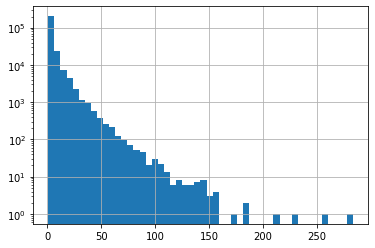

In [106]:
df_article_feat["feat_article_num_sales_1day"].hist(bins=50, log=True)

<AxesSubplot:>

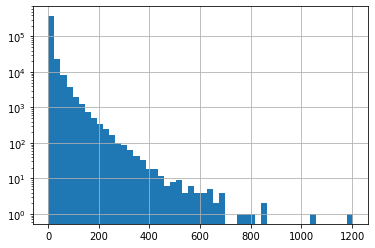

In [104]:
df_article_feat["feat_article_num_sales_3day"].hist(bins=50, log=True)

<AxesSubplot:>

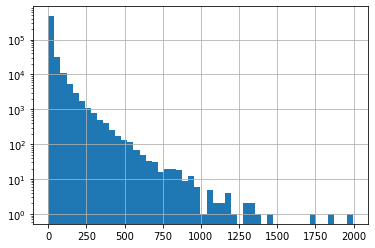

In [105]:
df_article_feat["feat_article_num_sales_7day"].hist(bins=50, log=True)